In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
pd.set_option('display.max_rows', 500)
pd.set_option("display.precision", 10)

## Load data

In [42]:
df = pd.read_csv("./data/titanic.csv")

In [43]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Les ages manquant dans le CSV sont remplacés par un age 0

In [44]:
def prepare(df):
    df.Age.fillna(0,inplace=True)
    df.Age = df.Age.astype(float)
    return df

In [45]:
df = prepare(df)

<AxesSubplot:>

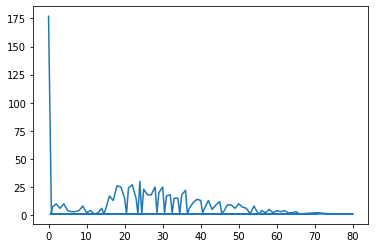

In [46]:
df.Age.sort_values().value_counts(sort=False).plot()

## Exemple d'index

In [47]:
values_to_lookup = df.sample(10).Age
values_to_lookup

581    39.0
49     18.0
570    62.0
850     4.0
256     0.0
36      0.0
596     0.0
700    18.0
788     1.0
728    25.0
Name: Age, dtype: float64

Un index c'est un tableau de paires (clé/valeur) triés par la clé.

Les ages sont nos clés, leurs positions respectives (offset) dans le document CSV sont nos valeurs

In [48]:
index = []
for i in range(values_to_lookup.count()):
    key = values_to_lookup.iloc[i]
    value = values_to_lookup.index[i]
    index.append((key, value))
index.sort()
index

[(0.0, 36),
 (0.0, 256),
 (0.0, 596),
 (1.0, 788),
 (4.0, 850),
 (18.0, 49),
 (18.0, 700),
 (25.0, 728),
 (39.0, 581),
 (62.0, 570)]

## calcul de la CDF

La Cumulative Distribution Function est une statistique qui représente la distribution des Ages dans notre CSV

In [49]:
def compute_stat(df):
    # compte combien de fois chaque valeur d'age est présente
    freq = df.Age.value_counts()

    # Probality Distribution Function : la fréquence sur la somme totale
    pdf = freq / sum(freq)

    # Cumulative Distribution Function : la somme cumulée de chaque PDF (triées !)
    cdf = pdf.sort_index().cumsum()

    return freq, pdf, cdf

In [50]:
freq, pdf, cdf = compute_stat(df)
cdf.head(10)

0.00    0.1986531987
0.42    0.1997755331
0.67    0.2008978676
0.75    0.2031425365
0.83    0.2053872054
0.92    0.2065095398
1.00    0.2143658810
2.00    0.2255892256
3.00    0.2323232323
4.00    0.2435465769
Name: Age, dtype: float64

<AxesSubplot:>

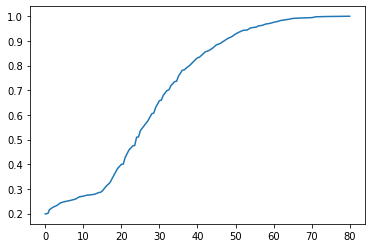

In [51]:
cdf.plot(x='Age')

## build the X and y

In [52]:
cols_to_drop = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Cabin', 'Sex', 'SibSp', 'Parch','Ticket', 'Fare', 'Embarked']
def build_sortedtable(df, cdf):
    # add a column Agecdf to the dataframe
    joined = df.join(pd.DataFrame(data=cdf), on='Age', rsuffix='cdf')

    # sort values by Age
    sorted_byage = joined.sort_values('Age')
    
    # use the index as a new column 'offset'
    sorted_table = sorted_byage.reset_index().rename(columns={'index': 'row_id'})

    # project Age as X and Agecdf as y
    return sorted_table.drop(cols_to_drop, axis=1)[['Age', 'row_id', 'Agecdf']]

In [53]:
sorted_table = build_sortedtable(df, cdf)

In [54]:
sorted_table.sample(10).sort_index() # X is the column Age, y is the cdf values

,Age,row_id,Agecdf
5,0.0,277,0.1986531987
254,14.5,111,0.2861952862
323,19.0,687,0.3827160494
369,21.0,37,0.4276094276
414,23.0,658,0.4747474747
432,24.0,139,0.5095398429
463,25.0,666,0.5364758698
465,25.0,785,0.5364758698
485,26.0,401,0.5566778900
804,48.0,771,0.9102132435


Scaling back the cdf to find the i element : sorted_table [[ CDF x num elements - 1 ]]

In [55]:
# the CDF x num elements - 1 == i-st element
print( 0.19865320 * sorted_table.Age.count() - 1 )
sorted_table[sorted_table.Age == 0].iloc[-1]

176.0000012


Age         0.0000000000
row_id    457.0000000000
Agecdf      0.1986531987
Name: 176, dtype: float64

## fit(cdf), predic(cdf), and scale the result

In [56]:
# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
regr.fit(sorted_table.Age[:,None], sorted_table.Agecdf)
print("f(x) = a + bx")
print("f(x) =", regr.intercept_, "+", regr.coef_[0], "x")

f(x) = a + bx
f(x) = 0.17909954104152764 + 0.014608876072520233 x


In [57]:
preds = pd.Series(name='preds',data=regr.predict(sorted_table.Age[:,None]))

In [79]:
all = pd.concat([sorted_table, preds], axis=1)

In [80]:
all.head()

,Age,row_id,Agecdf,preds
0,0.0,667,0.1986531987,0.179099541
1,0.0,128,0.1986531987,0.179099541
2,0.0,533,0.1986531987,0.179099541
3,0.0,284,0.1986531987,0.179099541
4,0.0,538,0.1986531987,0.179099541


In [81]:
all['guessed_i'] = pd.Series(all.preds * all.Age.count() - 1).round().astype(int)
all['true_i'] = all.reset_index()['index']

In [82]:
all.sample(15)

,Age,row_id,Agecdf,preds,guessed_i,true_i
796,47.0,871,0.9001122334,0.8657167164,770,796
244,11.0,802,0.2749719416,0.3397971778,302,244
473,25.0,884,0.5364758698,0.5443214429,484,473
748,41.0,761,0.8406285073,0.7780634600,692,748
2,0.0,533,0.1986531987,0.1790995410,159,2
477,25.0,343,0.5364758698,0.5443214429,484,477
166,0.0,330,0.1986531987,0.1790995410,159,166
678,36.0,741,0.7811447811,0.7050190797,627,678
763,43.0,314,0.8608305275,0.8072812122,718,763
601,31.0,318,0.6790123457,0.6319746993,562,601


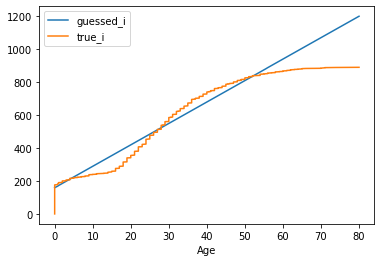

<AxesSubplot:>

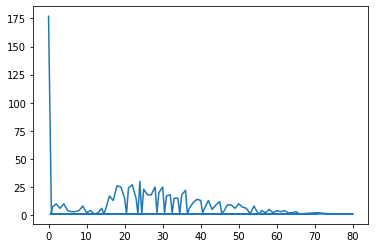

In [83]:
all[['Age', 'guessed_i', 'true_i']].plot(x='Age')
plt.show()
df.Age.sort_values().value_counts(sort=False).plot()

### Error, min & max residual

In [92]:
max_residual = max(all.true_i - all.guessed_i)
min_residual = min(all.true_i - all.guessed_i)
all['upper_bound'] = all.guessed_i + max_residual
all['lower_bound'] = all.guessed_i + min_residual

print("max:", max_residual)
print("min:", min_residual)

max: 68
min: -310


<AxesSubplot:xlabel='Age'>

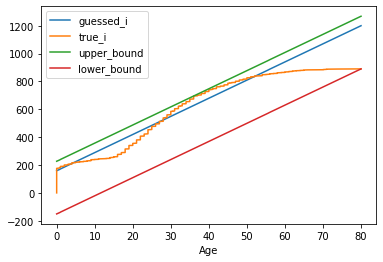

In [93]:
all[['Age', 'guessed_i', 'true_i', 'upper_bound', 'lower_bound']].plot(x='Age')

## Lookup

Grace à la prédiction du i et du résidu max et min, nous avons notre espace de recherche

In [94]:
import numpy as np
age_lookup = 23.0

In [95]:
guess23 = regr.predict(np.array([[age_lookup]]))
guess23[0]

0.515103690709493

In [96]:
i = int(np.round(guess23[0] * df.Age.count() -1)) # scale the cdf approximation with the number of elements
i

458

In [97]:
sorted_table.iloc[i] # look at indice i if its Age is equal to 23.0

Age        25.0000000000
row_id    134.0000000000
Agecdf      0.5364758698
Name: 458, dtype: float64

In [98]:
min_i = int(i + min_residual) # compute the lower bound
min_i

148

In [99]:
max_i = int(i + max_residual) # compute the upper bound
max_i

526

In [100]:
for i in range(min_i, i): # iterate from inferior bound to guessed i, because the Age of the indice i is 25 (>23)
    if sorted_table.iloc[i].Age == age_lookup:
        row_id = int(sorted_table.iloc[i].row_id + 2) # +2 because the CSV has headers and indice start at 1 (not 0)
        print("Age", age_lookup, "found in titanic.csv at line ", row_id)

Age 23.0 found in titanic.csv at line  395
Age 23.0 found in titanic.csv at line  651
Age 23.0 found in titanic.csv at line  352
Age 23.0 found in titanic.csv at line  531
Age 23.0 found in titanic.csv at line  475
Age 23.0 found in titanic.csv at line  735
Age 23.0 found in titanic.csv at line  660
Age 23.0 found in titanic.csv at line  755
Age 23.0 found in titanic.csv at line  818
Age 23.0 found in titanic.csv at line  400
Age 23.0 found in titanic.csv at line  99
Age 23.0 found in titanic.csv at line  835
Age 23.0 found in titanic.csv at line  736
Age 23.0 found in titanic.csv at line  90
Age 23.0 found in titanic.csv at line  137
